https://camelyon16.grand-challenge.org/Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings; warnings.filterwarnings('ignore')
from fastai.vision import *
sys.path.append("dev/")

In [3]:
path = Path('../data/histopathologic/'); path.ls()

[PosixPath('../data/histopathologic/tmp'),
 PosixPath('../data/histopathologic/preds'),
 PosixPath('../data/histopathologic/patch_id_wsi.csv'),
 PosixPath('../data/histopathologic/train'),
 PosixPath('../data/histopathologic/sample_submission.csv'),
 PosixPath('../data/histopathologic/models'),
 PosixPath('../data/histopathologic/ensemble'),
 PosixPath('../data/histopathologic/train_labels.csv'),
 PosixPath('../data/histopathologic/logs'),
 PosixPath('../data/histopathologic/submissions'),
 PosixPath('../data/histopathologic/test')]

In [4]:
len((path/'train').ls()), len((path/'test').ls())

(220025, 57458)

In [5]:
from fastai.vision.models import cadene_models 
def get_arch_by_name(arch_name):
    "grab model function by name"
    if hasattr(models, arch_name):
        return getattr(models, arch_name)
    elif hasattr(cadene_models, arch_name):
        return getattr(cadene_models, arch_name)
    else:
        raise Exception("Model not found in 'models' of 'cadene_models'")

### cv data

In [6]:
cv_data = pd.read_pickle(path/'models/cv_non_overlap_data.pkl')

In [7]:
len(cv_data)

5

### trained models

In [8]:
[o for o in (path/'models').ls() if 'best_of' in o.stem]

[PosixPath('../data/histopathologic/models/best_of_resnet152_non_overlap'),
 PosixPath('../data/histopathologic/models/best_of_densenet201_non_overlap'),
 PosixPath('../data/histopathologic/models/best_of_resnet152_224_more_aug'),
 PosixPath('../data/histopathologic/models/best_of_densenet169_non_overlap'),
 PosixPath('../data/histopathologic/models/best_of_dpn92_non_overlap'),
 PosixPath('../data/histopathologic/models/best_of_resnet101_non_overlap')]

In [9]:
arch_name = 'resnet152'
suffix = '_non_overlap'
MODEL_NAME = f'{arch_name}{suffix}'

### logs

In [10]:
pd.options.display.max_rows=1000

In [11]:
(path/'logs').ls()

[PosixPath('../data/histopathologic/logs/resnet152_non_overlap.csv'),
 PosixPath('../data/histopathologic/logs/densenet201_non_overlap.csv'),
 PosixPath('../data/histopathologic/logs/resnet152_224_more_aug.csv')]

In [12]:
LOG_FILE = path/f'logs/{MODEL_NAME}.csv'
if (LOG_FILE).exists():
    log_df = pd.read_csv(LOG_FILE)

### read data

In [13]:
from metric_utils import AUC
from fastai.callbacks import *

In [14]:
i = 0
fold_num = i
fold_data = cv_data[i]

### init learn

In [15]:
auc = AUC()
arch = get_arch_by_name(arch_name)
model_name = arch.__name__ 
learn = cnn_learner(data=fold_data, base_arch=arch, metrics=[accuracy, auc], 
                lin_ftrs=[1024,1024], ps=[0.7, 0.7, 0.7],
                callbacks=[],
                callback_fns=[])

### Interpretation

In [16]:
load_fold_num = 0
learn.load(f'best_of_{MODEL_NAME}/fold{load_fold_num}');

In [17]:
interp = ClassificationInterpretation.from_learner(learn, ds_type=DatasetType.Valid)

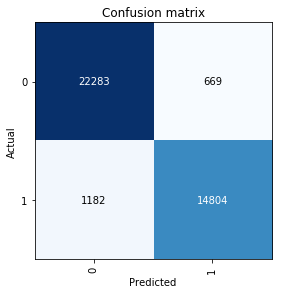

In [18]:
# no TTA
interp.plot_confusion_matrix()

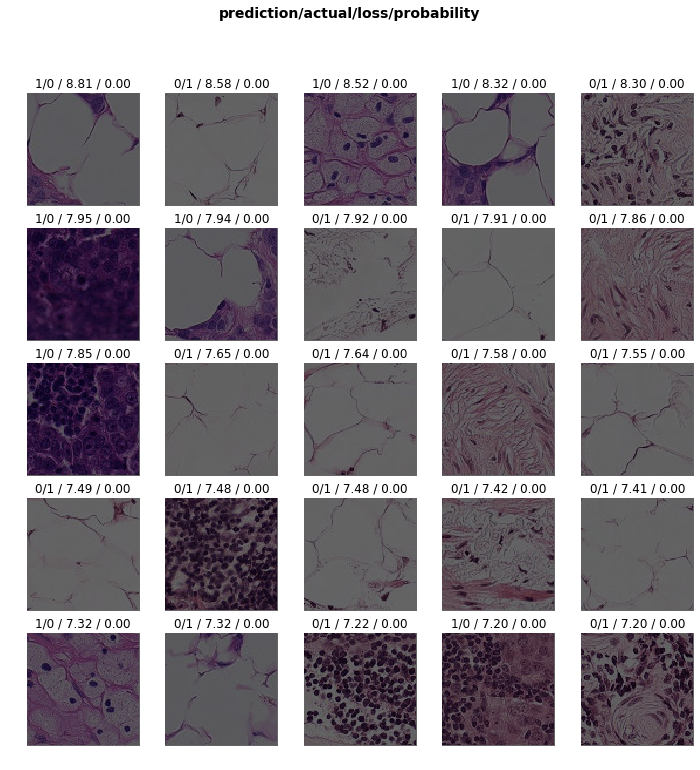

In [19]:
# Grad CAM
fig = interp.plot_top_losses(25, heatmap=True, heatmap_thresh=0, return_fig=True)

In [20]:
# indices of misclassified samples
is_incorrect = interp.y_true != interp.pred_class; torch.sum(is_incorrect)
# probabilities assigned to argmax 
pred_probs = torch.gather(interp.probs, dim=1, index=interp.pred_class.view(-1,1)).view(-1)
# probabilities of misclassified samples
confused_probs = pred_probs.masked_select(is_incorrect)
# ground truth labels of misclassified samples
confused_y_true = interp.y_true.masked_select(is_incorrect)
# confused label misclassified samples
confused_label = interp.pred_class.masked_select(is_incorrect)

len(confused_y_true), len(confused_probs)

(1851, 1851)

In [21]:
valid_fnames = learn.data.valid_ds.x.items
confused_valid_fn = valid_fnames[to_np(is_incorrect)]
confused_fn = valid_fnames[(to_np(is_incorrect)).astype(bool)]
confused_idxs = np.arange(len(valid_fnames))[(to_np(is_incorrect)).astype(bool)]
len(confused_fn)

1851

In [22]:
# create most confused samples dataframe
confused_samples_df = (pd.DataFrame({'fn':confused_fn,
     'true_label':to_np(confused_y_true),
     'confused_label':to_np(confused_label),
     'confused_probs':to_np(confused_probs),
     'confused_idxs':confused_idxs})
    .sort_values("confused_probs", ascending=False)
    .reset_index(drop=True))

In [23]:
confused_samples_df.head()

,fn,true_label,confused_label,confused_probs,confused_idxs
0,/data/users/turgutluk/histopathologic/train/06...,0,1,0.999851,1394
1,/data/users/turgutluk/histopathologic/train/60...,1,0,0.999812,36987
2,/data/users/turgutluk/histopathologic/train/3e...,0,1,0.999801,19468
3,/data/users/turgutluk/histopathologic/train/95...,0,1,0.999757,38643
4,/data/users/turgutluk/histopathologic/train/f4...,1,0,0.999752,7136


In [24]:
confused_samples_df.true_label.mean()

0.6385737439222042

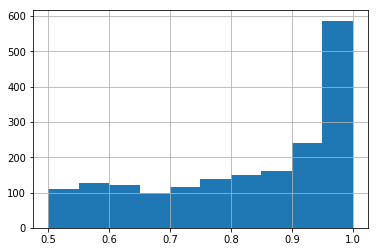

In [25]:
confused_samples_df.confused_probs.hist()

### read logs

In [26]:
pd.options.display.max_rows = 1000

def plot_logs(model_name='densenet201', size=(20,10)):
    log_df = pd.read_csv(path/f'logs/{model_name}.csv')    
    metrics = [] 
    for o in log_df['auc']:
        if isinstance(o, float) and (not np.isnan(o)):
            metrics.append(o)
        elif isinstance(o, str) and (o != 'auc'):
            metrics.append(float(o))
    metrics = [np.round(o,4) for o in metrics]
    fig,ax = plt.subplots(1,1, figsize=size)
    ax.set_title(model_name +': '+str(max(metrics)), {'fontsize':size[0]})
    ax.plot(metrics)
    ax.scatter(np.argmax(metrics), max(metrics), c='red')
    ax.hlines(max(metrics), xmin=0, xmax=len(metrics), colors='red', linestyles = 'dashed')
    plt.yticks(list(plt.yticks()[0]) + [max(metrics)])
    for t in ax.yaxis.get_major_ticks(): t.label.set_fontsize(size[0])  
    for t in ax.xaxis.get_major_ticks(): t.label.set_fontsize(size[0])  
    return log_df

In [27]:
(path/'logs').ls()

[PosixPath('../data/histopathologic/logs/resnet152_non_overlap.csv'),
 PosixPath('../data/histopathologic/logs/densenet201_non_overlap.csv'),
 PosixPath('../data/histopathologic/logs/resnet152_224_more_aug.csv')]

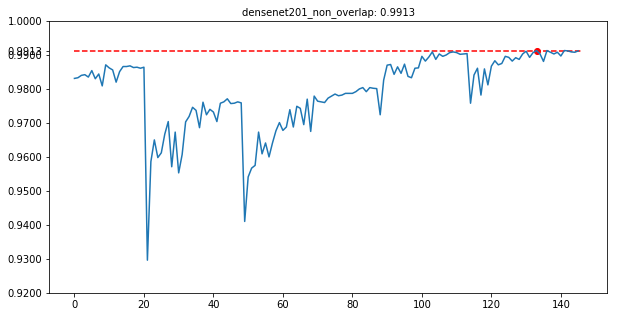

In [28]:
log_df = plot_logs('densenet201_non_overlap', (10,5))

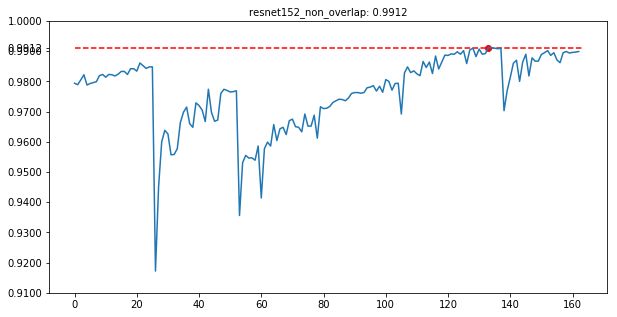

In [29]:
log_df = plot_logs('resnet152_non_overlap', (10,5))

## Get Preds and Subs

In [30]:
# create preds and submissions directory for the model
os.makedirs(path/f'preds/best_of_{MODEL_NAME}', exist_ok=True)
os.makedirs(path/f"submissions/best_of_{MODEL_NAME}", exist_ok=True)

In [31]:
auc = AUC()
arch = get_arch_by_name(arch_name)
model_name = arch.__name__ 
learn = cnn_learner(data=fold_data, base_arch=arch, metrics=[accuracy, auc], 
                lin_ftrs=[1024,1024], ps=[0.7, 0.7, 0.7],
                callbacks=[],
                callback_fns=[])

In [32]:
folds = (path/f'models/best_of_{MODEL_NAME}').ls()
n_folds = len(folds)
folds, n_folds

([PosixPath('../data/histopathologic/models/best_of_resnet152_non_overlap/fold3.pth'),
  PosixPath('../data/histopathologic/models/best_of_resnet152_non_overlap/fold0.pth'),
  PosixPath('../data/histopathologic/models/best_of_resnet152_non_overlap/fold1.pth'),
  PosixPath('../data/histopathologic/models/best_of_resnet152_non_overlap/fold2.pth'),
  PosixPath('../data/histopathologic/models/best_of_resnet152_non_overlap/fold4.pth')],
 5)

### get preds

In [33]:
for load_fold_num in range(n_folds):
    fn = path/f'preds/best_of_{MODEL_NAME}/fold{load_fold_num}_preds.pkl'
    if not fn.exists():
        learn.load(f'best_of_{MODEL_NAME}/fold{load_fold_num}');
        test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)
        pd.to_pickle(test_preds, fn) 
    else: print(f"{fn} already exists")

../data/histopathologic/preds/best_of_resnet152_non_overlap/fold0_preds.pkl already exists
../data/histopathologic/preds/best_of_resnet152_non_overlap/fold1_preds.pkl already exists
../data/histopathologic/preds/best_of_resnet152_non_overlap/fold2_preds.pkl already exists
../data/histopathologic/preds/best_of_resnet152_non_overlap/fold3_preds.pkl already exists
../data/histopathologic/preds/best_of_resnet152_non_overlap/fold4_preds.pkl already exists


### get_preds with default TTA

In [34]:
for load_fold_num in range(n_folds):
    fn = path/f'preds/best_of_{MODEL_NAME}/fold{load_fold_num}_TTA_preds.pkl'
    if not (fn).exists():
        learn.load(f'best_of_{MODEL_NAME}/fold{load_fold_num}');
        tta_preds,_  = learn.TTA(ds_type=DatasetType.Test, beta=0.4, scale=1.0)
        pd.to_pickle(tta_preds, fn) 
    else: print(f"{fn} already exists")

../data/histopathologic/preds/best_of_resnet152_non_overlap/fold0_TTA_preds.pkl already exists
../data/histopathologic/preds/best_of_resnet152_non_overlap/fold1_TTA_preds.pkl already exists
../data/histopathologic/preds/best_of_resnet152_non_overlap/fold2_TTA_preds.pkl already exists
../data/histopathologic/preds/best_of_resnet152_non_overlap/fold3_TTA_preds.pkl already exists
../data/histopathologic/preds/best_of_resnet152_non_overlap/fold4_TTA_preds.pkl already exists


### get_preds with TTA (beta=0.2, scale=1.0)

In [35]:
for load_fold_num in range(n_folds):
    fn = path/f'preds/best_of_{MODEL_NAME}/fold{load_fold_num}_custom_TTA_preds.pkl'
    if not fn.exists():
        learn.load(f'best_of_{MODEL_NAME}/fold{load_fold_num}');
        tta_preds,_  = learn.TTA(ds_type=DatasetType.Test, beta=0.2, scale=1.0)
        pd.to_pickle(tta_preds, fn)    
    else: print(f"{fn} already exists")

### get_preds with more TTA 

In [36]:
import torchvision.transforms as torch_tfms
from transform_utils import torchvision_composed

In [37]:
composed_transform = torch_tfms.Compose([
    torch_tfms.RandomChoice([
        torch_tfms.ColorJitter(brightness=0.5),
        torch_tfms.ColorJitter(contrast=0.5), 
        torch_tfms.ColorJitter(saturation=0.5),
        torch_tfms.ColorJitter(hue=0.5),
        torch_tfms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
        torch_tfms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), 
        torch_tfms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), 
    ]),
    torch_tfms.RandomGrayscale(p=.3)
])

In [38]:
xtra_tfms = [torchvision_composed(composed_tfms=composed_transform, p=1.)]

In [39]:
def _custom_tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid,
                     scale:float=1.0, xtra_tfms:list=[], n_tta:int=8) -> Iterator[List[Tensor]]:
    "Computes the outputs for several augmented inputs for TTA"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    augm_tfm = [o for o in learn.data.train_ds.tfms if o.tfm not in
               (crop_pad, flip_lr, dihedral, zoom)] + xtra_tfms
    try:
        pbar = master_bar(range(n_tta))
        for i in pbar:
            row = 1 if i&1 else 0
            col = 1 if i&2 else 0
            flip = i&4
            d = {'row_pct':row, 'col_pct':col, 'is_random':False}
            tfm = [*augm_tfm, zoom(scale=scale, **d), crop_pad(**d)]
            if flip: tfm.append(flip_lr(p=1.))
            ds.tfms = tfm
            yield get_preds(learn.model, dl, pbar=pbar, activ=_loss_func2activ(learn.loss_func))[0]
    finally: ds.tfms = old

Learner.custom_tta_only = _custom_tta_only

In [40]:
def _custom_TTA(learn:Learner, beta:float=0.2, scale:float=1.0, 
                ds_type:DatasetType=DatasetType.Valid, with_loss:bool=False, 
                xtra_tfms:list=[], n_tta:int=8) -> Tensors:
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(ds_type)
    all_preds = list(learn.custom_tta_only(scale=scale, ds_type=ds_type, xtra_tfms=xtra_tfms, n_tta=n_tta))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:            
        final_preds = preds*beta + avg_preds*(1-beta)
        if with_loss: 
            with NoneReduceOnCPU(learn.loss_func) as lf: loss = lf(final_preds, y)
            return final_preds, y, loss
        return final_preds, y

Learner.custom_TTA = _custom_TTA

In [ ]:
from fastai.basic_train import _loss_func2activ

In [ ]:
for load_fold_num in range(n_folds):
    learn.load(f'best_of_{MODEL_NAME}/fold{load_fold_num}')
    custom_tta_preds,_  = learn.custom_TTA(ds_type=DatasetType.Test, xtra_tfms=xtra_tfms)
    pd.to_pickle(custom_tta_preds, path/f'preds/best_of_{MODEL_NAME}/fold{load_fold_num}_custom_TTA_preds.pkl')    

### create submissions

simple average of all folds

In [ ]:
sample_submission = pd.read_csv(path/'sample_submission.csv')
test_names = [o.name.split('.')[0] for o in learn.data.test_ds.items]

In [ ]:
pred_fnames = (path/f'preds/best_of_{MODEL_NAME}').ls()

In [ ]:
pred_fnames

In [ ]:
TTA_fnames = [o for o in pred_fnames if ("TTA" in str(o)) and ("custom" not in str(o))]
custom_TTA_fnames = [o for o in pred_fnames if ("TTA" in str(o)) and ("custom" in str(o))]
non_TTA_fnames = [o for o in pred_fnames if "TTA" not in str(o)]

In [ ]:
# average TTA_preds
avg_TTA_labels = np.mean([pd.read_pickle(fn).numpy() for fn in TTA_fnames], axis=0)[:, 1]
avg_custom_TTA_labels = np.mean([pd.read_pickle(fn).numpy() for fn in custom_TTA_fnames], axis=0)[:, 1]
avg_non_TTA_labels = np.mean([pd.read_pickle(fn).numpy() for fn in non_TTA_fnames], axis=0)[:, 1]

In [ ]:
# create submission file
avg_TTA_submission = sample_submission.copy()
avg_custom_TTA_submission = sample_submission.copy()
avg_non_TTA_submission = sample_submission.copy()

avg_TTA_submission['label'] = sample_submission['id'].map(dict(zip(test_names, avg_TTA_labels)))
avg_custom_TTA_submission['label'] = sample_submission['id'].map(dict(zip(test_names, avg_TTA_labels)))
avg_non_TTA_submission['label'] = sample_submission['id'].map(dict(zip(test_names, avg_non_TTA_labels)))

In [ ]:
# save submissions
avg_TTA_path = path/f"submissions/best_of_{MODEL_NAME}/{MODEL_NAME}_avg_TTA.csv"
avg_custom_TTA_path = path/f"submissions/best_of_{MODEL_NAME}/{MODEL_NAME}_avg_custom_TTA.csv"
avg_non_TTA_path = path/f"submissions/best_of_{MODEL_NAME}/{MODEL_NAME}_avg_non_TTA.csv"

avg_TTA_submission.to_csv(avg_TTA_path, index=False)
avg_custom_TTA_submission.to_csv(avg_custom_TTA_path, index=False)
avg_non_TTA_submission.to_csv(avg_non_TTA_path, index=False)

In [ ]:
# Submit to kaggle
# cmd1 = "kaggle competitions submit -c histopathologic-cancer-detection -f {} -m {}_avg_TTA".format(avg_TTA_path, model_name)
cmd2 = "kaggle competitions submit -c histopathologic-cancer-detection -f {} -m {}_avg_custom_TTA".format(avg_custom_TTA_path, model_name)
# cmd3 = "kaggle competitions submit -c histopathologic-cancer-detection -f {} -m {}_avg_non_TTA".format(avg_non_TTA_path, model_name)
# os.system(cmd1)
os.system(cmd2)
# os.system(cmd3)

### fin